# Building CNNs with Keras


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Motivation: The Image Recognition Problem

Convolutional Neural Networks (CNNs) are a special type of network primarily
used for image recognition. To understand their advantage over fully connected
networks consider a simple coloured image of size 32x32. Because it is coloured,
it has dimensions 32x32x3, which means there are around 3000 features. If we
wanted a fully connected network with just 1000 nodes in the first level (far
too few to get good performance), we would have millions of edges to adjust.
CNNs get around this in a rather creative way. Before we examine the structure
of the network, we first need to understand what a convolution operation is.


## Convolution

A convolution is similar to an element-wise multiplication between two matrices
or tensors.

An intuitive explanation of how convolutions work can be found
[here](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/). The
following images are taken from this source.

Let's say we have a 5x5 image which has some numbers between 0 and 255 at each
pixel,

<img src="https://drive.google.com/uc?export=view&id=19aurkTj59Ym3k2mKkR_XnrbusqBg6UbG" width=150/>

and a kernel or a window of size 3x3.

<img src="https://drive.google.com/uc?export=view&id=1ps7ku1glheD2fEYWnjoot8o4WcVAuHWb" width=100 />

A convolution means that we are taking the kernel and sliding it across the
image, performing element-wise multiplication at each step, to create a
transformed version of our original image, as demonstrated below.

<img src="https://drive.google.com/uc?export=view&id=1UBIny57ZrDIGidhMkAYmpx6Z6KkLz52X" width=400/>


### Convolution as an Image Filter

A common application of convolutions is to apply a filter to an image. Based on
which kernel we use, we can get different effects on the images, as seen below:

<img src="https://drive.google.com/uc?export=view&id=18tvjZs4JPzKtM--sZ5Zmxi8Jj6TCrZuY" width=400/>


#### Examples

Let's look at some examples of convolutions on a sample image from the MNIST
data set.


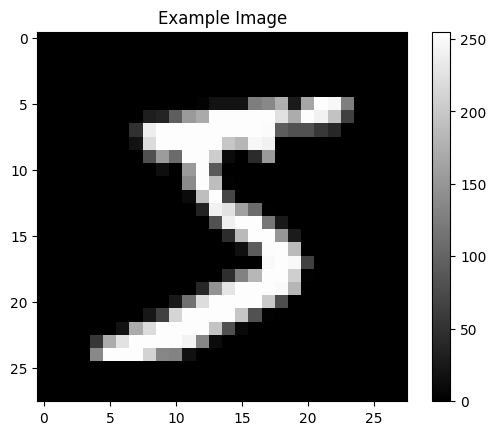

In [20]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Use the first image from this dataset as an example.
x = X_train[0]

plt.figure()
plt.title("Example Image")
plt.imshow(x, cmap="gray")
plt.colorbar()
plt.show()


Even though this is an image, it is represented by a 28x28 array of pixel values
between 0 and 255. A convolution is just a high-dimensional window function. For
example, the convolution could work over a 3x3 window of the original image and
output the dot product of that window with a 3x3 kernel. We slide this window
over the entire image, calculating the convolution of every 3x3 patch,
(including overlapping ones,) and get a new array of values back. These values
can be interpreted as a new image, (possibly with a different shape).

Using the `scipy.signal` module, we can compute the convolution of the following
box blur kernel:


In [21]:
box_blur_filter = np.full((3, 3), 1 / 9)
box_blur_filter


array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

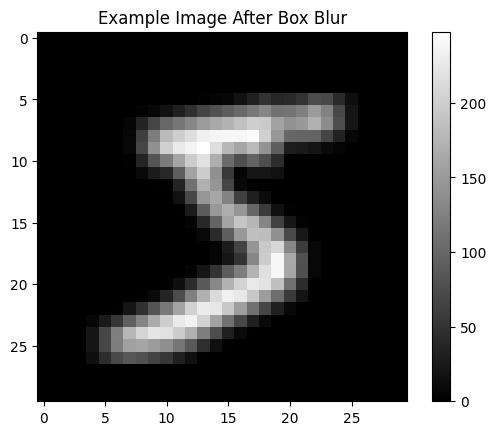

In [22]:
from scipy import signal

conv_image = signal.convolve2d(x, box_blur_filter)

plt.figure()
plt.title("Example Image After Box Blur")
plt.imshow(conv_image, cmap="gray")
plt.colorbar()
plt.show()


The top-left pixel of this new image is the convolution function applied to the
top-left 3x3 patch of the original image. (Actually, it's the top left patch
with a margin added onto it, but we can ignore that.) The pixel to its right is
the convolution function applied to the next 3x3 patch. The convolution is
essentially a feature detector: it outputs large values when the area of the
image is similar to the kernel, and it outputs smaller values when the kernel &
image area are different.

Let's perform another convolution on this image, but this time using the edge
detection filter.


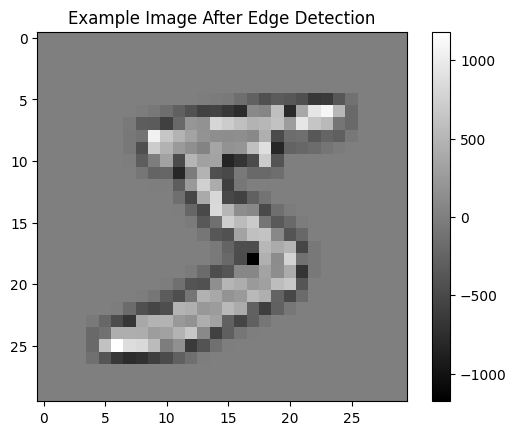

In [23]:
edge_detection_filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

conv_image = signal.convolve2d(x, edge_detection_filter)

plt.figure()
plt.title("Example Image After Edge Detection")
plt.imshow(conv_image, cmap="gray")
plt.colorbar()
plt.show()


After applying this convolution, the output image contains an outline around the
edge of the number. This could be quite useful if we fed it to model.


### Convolutions for Image Processing

Before the rise of neural networks, a large portion of image processing
algorithms relied on these hand-crafted convolutions in combination with other
algorithms to solve problems. When we use convolutional neural networks, instead
of specifying the specific kernel, we let the neural network learn the most
useful kernels during training.


## Building a Convolutional Neural Network


### Neural Network Convolutions

What do these convolution functions have to do with neural networks? The
convolution output is similar to the sum of the element-wise product of two
tensors, the weight tensor $W$ and the input tensor $X$, that we have seen used
previously in feed-forward networks:

$$\sum_i W_i X_i$$

The convolution is similar to this, but instead of multiplying the weight tensor
$W$ by the entire input, it only applies it to a portion (window) at a time.
Effectively, we are sliding this convolution function over the image and passing
its output into a neuron in the next layer. The convolutional tensor $W$, ends
up being a collection of edge weights that can be used to identify specific
patterns in our input layer.

Let's go back to our initial example of building a fully connected network for
the MNIST data set. Each neuron in the first layer would have 784 input weights
because each input image has 784 pixels. However, if we slide the convolutional
tensor over the input instead, we only need to train the number of weights in
our convolutional tensor. Now, we still need a neuron for every window we slide
our function over, but these neurons will share the same weights. That is, if we
are using a convolution with 9 weights (so it has dimensions 3x3), then the
weights are the same for every window of an image we apply it to. Effectively
each pixel in our convolved image is the input to some neuron in the next layer.


### CNNs for Colored Images


<img src="https://drive.google.com/uc?export=view&id=1zXk6ZfpIxDGoDK7X-1kHaDGbEofrpKp6" />


In the above image, we start off with a 227x227 colored image, hence the
dimensions of the input data are 227x227x3. After using 96 convolutions, we end
up with a tensor of size 55x55x96. (We will discuss why the other dimensions
shrink from 227x227 to 55x55 shortly.) This is repeatedly done until we get to
the last convolution. After that, we flatten the tensor into fully connected
layers.

For a black and white image, the convolution is a matrix with 2 dimensions. For
an image with RGB color which has 3 colour channels, the convolution tensor will
have 3 dimensions.


#### Example: Colored Image

Let's investigate colored images further by looking at an example image from
`scipy`:


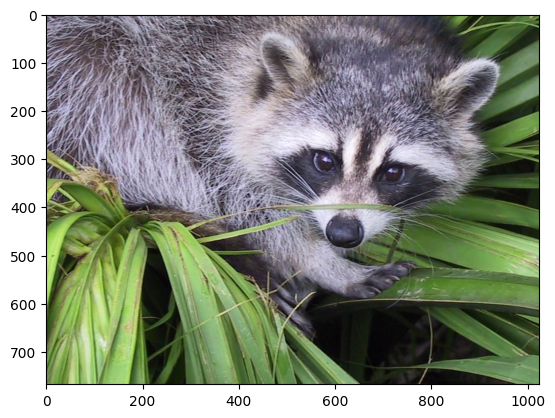

In [24]:
import scipy.misc

image = scipy.misc.face()

plt.imshow(image)
plt.show()


In [25]:
image.shape

(768, 1024, 3)

This image is an RGB image, so we can look at the three color channels:


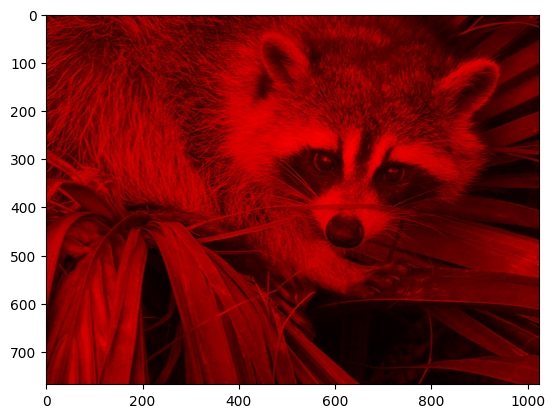

In [26]:
r = image.copy()
# setting green and blue channels to 0
r[:, :, 1] = 0
r[:, :, 2] = 0

plt.imshow(r)
plt.show()


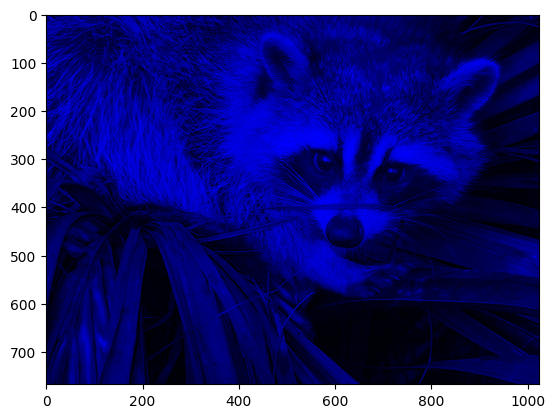

In [27]:
b = image.copy()
# setting red and green channels to 0
b[:, :, 0] = 0
b[:, :, 1] = 0

plt.imshow(b)
plt.show()


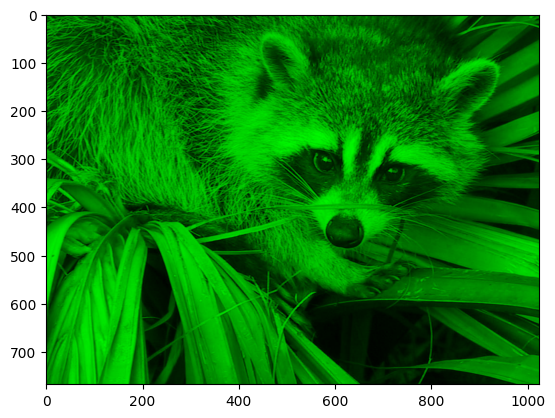

In [28]:
g = image.copy()
# setting red and blue channel
g[:, :, 0] = 0
g[:, :, 2] = 0

plt.imshow(g)
plt.show()


Our convolution would just be a sliding set of neural network edge weights over
the same patches in each channel.

If we wanted to have a convolution kernel of width 5 and height 5 (i.e. 5x5), it
would also need to have a depth of 3 to account for the 3 color channels in the
image, (i.e. the kernel would have dimensions 5x5x3).


### Advantages of Using Convolutions

There are a few major advantages to using convolutions:

1. **Reduces the number of weights:** As we mentioned before, we greatly reduce
   the number of weights we need to learn. For each convolution we apply, we
   only need to learn a number of weights relative to the size of the underlying
   window.
2. **Learns local features:** We force the network to learn local features. In a
   fully connected network, a neuron in the second layer would try and combine
   info from every pixel, even pixels that are far apart. By only getting inputs
   from a fixed size window, only local features will be learned.
3. **Can have multiple convolutional layers in a network:** Since a
   convolutional layer applied to some input image returns us some new output
   "image", we can apply another set of convolution functions to this output and
   get a newer "image". We can repeat this process over and over. As we go
   deeper into the network, the convolutional windows begin applying to larger
   and larger patches of the original image.

The last point is important. Each level of convolutions is learning more complex
features. The first levels often learn to pick up edges, the next levels learn
to combine these edges into shapes and eventually we get objects out of them.


### Reducing the Complexity of CNNs

To get good performance, we often need to increase the "depth" of our models as
this allows us to learn much more complex features. But this can lead to the
issue of having too many parameters to learn.


#### Stride

To compensate for this, we don't always need to consider every window when
applying our convolutions. Instead of a smooth sweep of the convolution, we jump
ahead a few pixels at a time. This reduces the "height" and "width" of the next
image. The amount we shift the window by is called the _stride_.


#### Pooling Layers

Another method to reduce the number of weights in a network is to apply
_pooling_. Pooling works by combining nearby outputs from a neuron to reduce the
resolution of the data for the next layer.

Similar to convolutions, pooling is accomplished by sliding a window over the
output of a layer and combining all of the outputs in that window to a new
single output. The two most common methods for combining the outputs are:

- **Max Pooling**: Take the maximum value within the window as the new output.
- **Average Pooling:** Take the average value within the window as the new
  output.

<img src="https://drive.google.com/uc?export=view&id=12HFVCwnIoL0_VgELJIXTSXLxfCHGcMli"/>

_Image Source:
https://indoml.com/2018/03/07/student-notes-convolutional-neural-networks-cnn-introduction/_


## Building a CNN in TensorFlow

Now that we have established some of the theory behind convolutional neural
networks, let's look at how to build them using TensorFlow. While CNNs are
pretty complex under the hood, the Keras API for TensorFlow makes it very easy
to create custom CNNs.


### Preparing The Data

We will start by loading the MNIST data directly from the TensorFlow API.


In [29]:
# Load the data, split between the train and test sets by default
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Check out the data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


We have 60,000 images for training and 10,000 images for testing. Let's also
take a look at the range of values in our data.


In [30]:
# range of x values
print(f"X range: {X_train.min()}-{X_train.max()}")
# y unique values
print(f"y values: {np.unique(y_train)}")
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")


X range: 0-255
y values: [0 1 2 3 4 5 6 7 8 9]
Number of classes: 10


A Keras model expects image data input to be passed in as a 4D tensor, such
that:

<code>image.shape </code>

should be in form:

<code>(n_images, img_rows, img_cols, n_channels)</code>


In [31]:
# Define input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Keras model types
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


Any model that has to calculate weights will be affected by scaling. Here we
modify the pixel values to fall between 0 and 1 before passing the values into
the CNN.


In [32]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print(f"X_train range: {X_train.min()}-{X_train.max()}")


X_train range: 0.0-1.0


### Building the model architecture

Now that our data is scaled and reshaped to the proper form, we can build our
model. There are a couple of ways to do this, but we will use the easiest way,
which is to build each layer sequentially using the Keras sequential model API:

<code> keras.models.Sequential </code>.

This allows us to simply construct each layer one at a time by adding them to
this Sequential model. A common pattern that you will see in almost all CNN
architectures is Convolutional layers used to extract features:

<code> keras.layers.Conv2D </code>

Followed by a pooling layer to reduce dimensionality:

<code> keras.layers.MaxPooling2D </code>

This Convolution + Pooling sequence is repeated until the dimensionality has
been lowered enough (which is a subjective decision).

At this point, the output of is flattened to prepare it for the final hidden
layers:

<code> keras.layers.Flatten </code>

After our data is flattened, we will typically have a few dense layers:

<code> keras.layers.Dense </code>

These dense layers will use the features that were learned from the
convolutional layers to make the final prediction. As usual, the final
prediction layer has its output size set to the number of classes.

Dropout is also commonly used in CNNs as a form of regularization to reduce
over-fitting:

<code> keras.layers.Dropout </code>


In [33]:
# Specific neural network models & layer types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


In [34]:
CNN_model = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction
# and Dropout to reduce overfitting
CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(64, (3, 3), activation="relu"))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten())

# Add dense layers
CNN_model.add(Dense(128, activation="relu"))
CNN_model.add(Dense(64, activation="relu"))
CNN_model.add(Dense(num_classes, activation="softmax"))

# Print out a summary of the network
CNN_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 64)         

In [18]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])


### Train the Model


In [19]:
# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
# THIS WILL TAKE A LONG TIME TO RUN!!!
CNN_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
375/375 [==============================] - 19s 49ms/step - loss: 0.3176 - accuracy: 0.8989 - val_loss: 0.0854 - val_accuracy: 0.9750
Epoch 2/10
375/375 [==============================] - 22s 58ms/step - loss: 0.0889 - accuracy: 0.9721 - val_loss: 0.0568 - val_accuracy: 0.9821
Epoch 3/10
375/375 [==============================] - 22s 58ms/step - loss: 0.0627 - accuracy: 0.9807 - val_loss: 0.0481 - val_accuracy: 0.9857
Epoch 4/10
375/375 [==============================] - 23s 60ms/step - loss: 0.0515 - accuracy: 0.9832 - val_loss: 0.0467 - val_accuracy: 0.9860
Epoch 5/10
375/375 [==============================] - 22s 59ms/step - loss: 0.0420 - accuracy: 0.9864 - val_loss: 0.0376 - val_accuracy: 0.9883
Epoch 6/10
375/375 [==============================] - 22s 59ms/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 0.0374 - val_accuracy: 0.9884
Epoch 7/10
375/375 [==============================] - 21s 57ms/step - loss: 0.0327 - accuracy: 0.9895 - val_loss: 0.0338 - val_accuracy:

### Evaluate the Model


In [18]:
# Evaluate the model's performance on the test data
score = CNN_model.evaluate(X_test, y_test, verbose=1)

print("Test loss:", score[0])
print("Test accuracy:", score[1])


313/313 [==============================] - 1s 3ms/step - loss: 0.0306 - accuracy: 0.9901
Test loss: 0.03062516450881958
Test accuracy: 0.9901000261306763


Here we've used a relatively simple CNN architecture and achieve an accuracy of
~99%, a pretty high value considering we are detecting 10 different classes!


---

#### Exercise 1

1. Build a CNN model with a Convolution layer with 32 nodes, one max pooling
   layer, one flatten layer, and a final dense output layer.

2. Check the model's accuracy and runtime.

3. Add additional convolution layers and compare the accuracy/ runtime. Which
   model performed better and why?


In [19]:
# 1. Build a CNN model with a Convolution layer with 32 nodes, one max pooling layer,
#    one flatten layer, and a final dense output layer.

E1_model = Sequential()
E1_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
E1_model.add(MaxPooling2D(pool_size=(2, 2)))
E1_model.add(Flatten())
E1_model.add(Dense(10, activation="softmax"))
E1_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Prep for Q2 - Compile & Fit the Model.
E1_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

E1_model.fit(X_train, y_train, batch_size=100, epochs=5, verbose=1, validation_split=0.2)

# 2. Check the model's accuracy and runtime.

score = E1_model.evaluate(X_test, y_test, verbose=1)

print("Test accuracy:", score[1])


Epoch 1/5
480/480 [==============================] - 7s 14ms/step - loss: 0.3532 - accuracy: 0.9044 - val_loss: 0.1522 - val_accuracy: 0.9606
Epoch 2/5
480/480 [==============================] - 6s 13ms/step - loss: 0.1244 - accuracy: 0.9646 - val_loss: 0.0986 - val_accuracy: 0.9736
Epoch 3/5
480/480 [==============================] - 6s 13ms/step - loss: 0.0868 - accuracy: 0.9755 - val_loss: 0.0822 - val_accuracy: 0.9783
Epoch 4/5
480/480 [==============================] - 6s 13ms/step - loss: 0.0704 - accuracy: 0.9804 - val_loss: 0.0749 - val_accuracy: 0.9782
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0625 - accuracy: 0.9803
Test accuracy: 0.9803000092506409


In [21]:
# 3. Add additional convolution layers and compare the accuracy/ runtime. Which model performed better and why?
E2_model = Sequential(
    [
        Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
        Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
        MaxPooling2D(2),
        Flatten(),
        Dense(10, activation="softmax"),
    ]
)
E2_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                92170     
Total params: 110,986
Trainable params: 110,986
Non-trainable params: 0
_________________________________________________________________


In [22]:
E2_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

E2_model.fit(X_train, y_train, batch_size=100, epochs=5, verbose=1, validation_split=0.2)

score = E2_model.evaluate(X_test, y_test, verbose=1)

print("Test accuracy:", score[1])


Epoch 1/5
480/480 [==============================] - 38s 79ms/step - loss: 0.2170 - accuracy: 0.9362 - val_loss: 0.0829 - val_accuracy: 0.9752
Epoch 2/5
480/480 [==============================] - 37s 78ms/step - loss: 0.0629 - accuracy: 0.9808 - val_loss: 0.0566 - val_accuracy: 0.9833
Epoch 3/5
480/480 [==============================] - 39s 82ms/step - loss: 0.0452 - accuracy: 0.9867 - val_loss: 0.0537 - val_accuracy: 0.9827
Epoch 4/5
480/480 [==============================] - 38s 78ms/step - loss: 0.0333 - accuracy: 0.9896 - val_loss: 0.0562 - val_accuracy: 0.9837
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.0463 - accuracy: 0.9860
Test accuracy: 0.9860000014305115


3. Continued: Which model performed better and why?

The second model with additional convolutional layers produced the higher test
accuracy. Adding layers increases the complexity of the model by increasing the
number of weights in the model.

Note: Adding additional layers will not always improve accuracy, for smaller
datasets adding additional layers can cause the model to overfit to the training
data which will lower the accuracy score.


In [23]:
##Bonus: the number of parameters is not the only determinant of accuracy.

E3_model = Sequential(
    [
        Conv2D(32, 3, input_shape=(28, 28, 1)),
        Conv2D(64, 3, input_shape=(28, 28, 1)),
        MaxPooling2D(2),
        Flatten(),
        Dense(10, activation="softmax"),
    ]
)
E3_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                92170     
Total params: 110,986
Trainable params: 110,986
Non-trainable params: 0
_________________________________________________________________


In [24]:
E3_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

E3_model.fit(X_train, y_train, batch_size=100, epochs=5, verbose=1, validation_split=0.2)

score = E3_model.evaluate(X_test, y_test, verbose=1)

print("Test accuracy:", score[1])


Epoch 1/5
480/480 [==============================] - 40s 83ms/step - loss: 0.2496 - accuracy: 0.9284 - val_loss: 0.1129 - val_accuracy: 0.9682
Epoch 2/5
480/480 [==============================] - 41s 85ms/step - loss: 0.0901 - accuracy: 0.9730 - val_loss: 0.0802 - val_accuracy: 0.9776
Epoch 3/5
480/480 [==============================] - 48s 101ms/step - loss: 0.0648 - accuracy: 0.9801 - val_loss: 0.0878 - val_accuracy: 0.9746
Epoch 4/5
480/480 [==============================] - 41s 86ms/step - loss: 0.0539 - accuracy: 0.9833 - val_loss: 0.0741 - val_accuracy: 0.9778
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - loss: 0.0804 - accuracy: 0.9763
Test accuracy: 0.9763000011444092


Since this is a multiclass classification problem, the accuracy score is only
one metric we should look at. We can use a confusion matrix to draw additional
insights on the performance of our model.


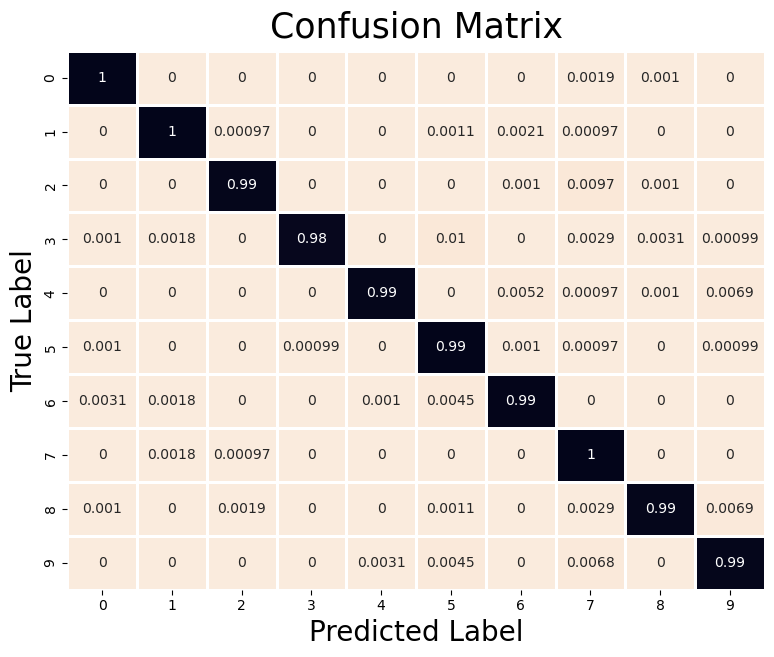

In [25]:
from sklearn.metrics import confusion_matrix

# Calculate the predicted labels for each test image.
predict_probas = CNN_model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)

# Create the confusion matrix using sklearn
conf_mat = confusion_matrix(y_test, y_predict)

# Since we have many images, it is helpful to show our
# results as fractions of the total number of images
# for each class.
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize=(9, 7))
sns.heatmap(normalized_conf_mat, annot=True, cbar=False, cmap="rocket_r", linewidths=1)
plt.title("Confusion Matrix", size=25, y=1.01)
plt.xlabel("Predicted Label", size=20)
plt.ylabel("True Label", size=20)
plt.show()


Based on this confusion matrix, it appears that our model is performing
exceptionally well across all classes. However, it is worth looking closely at
the results for numbers that people would often have a challenging time
distinguishing, as these are images that our model also tends to struggle with.
For example, 4 and 9, or 5 and 6.


Since we are working with images, we have an additional tool at our disposal. We
can look at some of the images that our model incorrectly predicted and try to
reason why our model might have predicted them wrong.


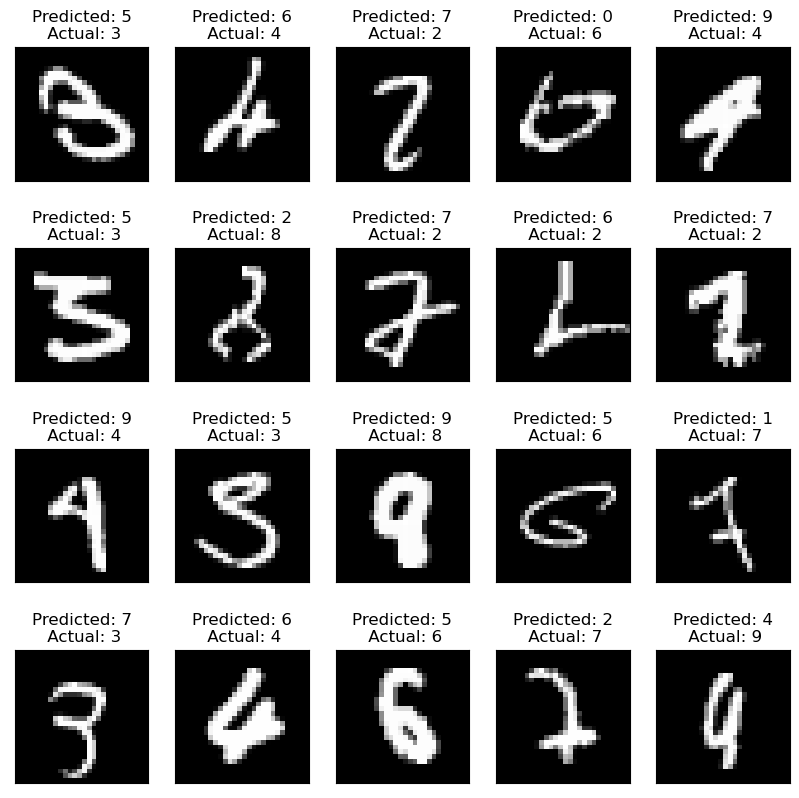

In [26]:
incorrect_photos = y_test != y_predict

num_images = 20
columns = 5
rows = 4

fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 10))

ax = ax.flatten()

for i, image in enumerate(X_test[incorrect_photos][:num_images]):
    ax[i].imshow(image, cmap="gray")

    # Get predicted label
    prediction = y_predict[incorrect_photos][i]

    # Get actual label
    actual = y_test[incorrect_photos][i]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()
fig.tight_layout()


Many of these images are arguably very poorly written and nearly impossible for
a human to identify correctly.


### CNN Summary

While the process is slightly more complex in terms of code, building a CNN
model with Keras still follows the same structure as building any other type of
supervised learning model:

1. Prepare the data
2. Instantiate the model
3. Fit the model
4. Evaluate its performance


## Transfer Learning


In the context of machine learning, transfer learning is the process of taking a
neural network model that has been previously trained on one dataset and
tweaking it slightly to work with a new dataset. This means we don't have to
train or design a model from scratch, which can be very valuable.


### When should we use transfer learning?

We can use transfer learning for many reasons, for instance:

- Not having enough training data to train a model
- Not having enough computing power to train a model
- Not having enough knowledge about deep learning to set up an extensive machine
  learning model (e.g. deep neural network)


### Transfer Learning for CNNs


Transfer learning is a very common technique with CNNs, although it can be
applied to all types of different network architectures.

When training CNNs, we are effectively creating a series of pattern detectors
that will learn to identify key distinguishing features within our data. The
final layers of CNN network, typically dense layers, are used to make the final
classifications on our training data images based on the features identified by
the convolutional layers.

For example, after training a CNN, the convolutional layers might be recognizing
image features like:

- colours
- horizontal and vertical lines
- closed or open shapes
- textures
- facial features (nose, eyes, etc.)
- body features (legs, tail, etc.), and so on.

Suppose the original network was trained to classify images of:

- houses
- planes
- birds
- dogs
- cats
- computers
- chairs

We can still use the convolutional layers from this CNN to classify images of
different monkey species without retraining the entire network from scratch. In
fact, neural networks trained on a set of data that doesn't even include these
classes in the new dataset can still perform quite well. This is because many of
the features that the convolutional layers were originally trained to identify
can also be distinguishing features in our new data set.


### The ImageNet dataset

Since 2010, ImageNet has been a benchmark for Large Scale Visual Recognition. It
consists of millions of images sorted into 1000 different classes ranging from
"blueberry" to "car". In 2011 a good classification error rate was 25%. In 2012,
a Deep CNN called AlexNet achieved an error rate of 16%, beating the runner up
by more than 10 percentage points. Since then CNNs have been the industry
standard in image classification with current state of the art error rates on
the ImageNet dataset being only a few percent.

More about ImageNet:
https://en.wikipedia.org/wiki/ImageNet#History_of_the_database

<img src="https://drive.google.com/uc?export=view&id=15VYngpFOoixZ-ErrMNqPn4VAZW5pY34X" width = 600 height = 500 >

Tensorflow has built into it several CNN architectures & weights that were
trained on the ImageNet dataset for us to import and tweak to our own learning
needs. This is one of the benefits of using Tensorflow.


### Outline of Transfer Learning

Below is the general outline of how we will apply transfer learning to a CNN
network:

1. Obtain a pre-trained CNN.
2. Strip off the final layers of the CNN.
3. Add some additional layers to the end of the pre-trained CNN that are
   designed to classify our data.
4. Hold the previously trained layers static (i.e. freeze their weights so they
   can't be re-trained)
5. Train only the newly created layers on our data to make a final model.


## Building a Deep Neural Network with Transfer Learning

For this example, we will use transfer learning to train a CNN that classifies
images of 10 different species of monkeys. You can download the data
[here](https://drive.google.com/file/d/1X6QR-TL2cz2rFVv7_a9KcIjhjoDlgJwA/view?usp=sharing).

_Note: This dataset comes from Kaggle and is publicly available:
https://www.kaggle.com/slothkong/10-monkey-species._


### Loading Images from Directories

In our first example we loaded data directly from the TensorFlow API, however,
in practice we will often need to load images directly from our computer's hard
drive. TensorFlow has a specific class, called `ImageDataGenerator` to help
facilitate this operation.


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#### Data Augmentation

The `ImageDataGenerator` class also allows us to use another popular neural
network training strategy called _data augmentation_. The basic idea of data
augmentation is to perform a series of random transformations on our training
data so that our neural networks become more robust. Some of the common
transformation used for images are:

- reflections
- rotations
- different crops (or zooms)
- shearing

Now that we have established some of the functionality of the
`ImageDataGenerator`, let's use it to load our images.


In [28]:
# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224
width = 224
channels = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, rotation_range=30, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator = train_datagen.flow_from_directory(
    "../_data/images/train", target_size=(height, width), color_mode="rgb", batch_size=32, class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    "../_data/images/validation", target_size=(height, width), color_mode="rgb", batch_size=32, class_mode="categorical"
)


Found 898 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


We can see that the `ImageDataGenerator` was automatically able to determine the
number of images and the classes based on the directory structure.

Generators are generally the best way to load images into your model. Instead of
loading all of the images into memory, generators only load a single batch at a
time. This makes it possible for your computer to handle very large data sets.

To load images from a generator, we can use the `.next()` method to grab the
next batch of images.


#### Visualize our Classes

Before we train any neural network, it is a good idea to get a feel for what our
data looks like. When working with images, one of the best methods is to look at
some sample images from each class.


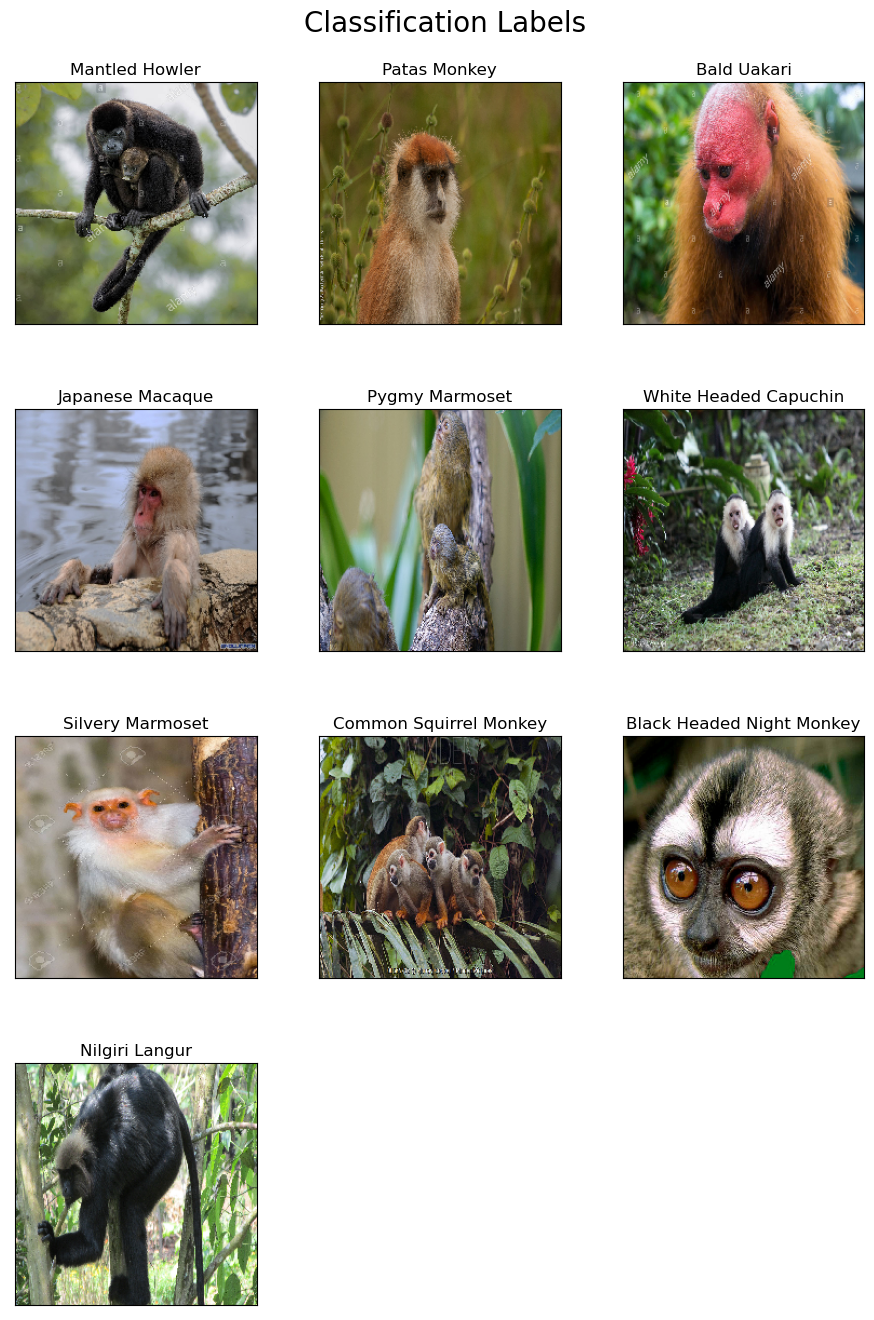

In [29]:
# Grab a batch of images from our validation generator:
x, y = validation_generator.next()

# Our images labels are one-hot encoded, lets
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)

monkey_names = [
    "Mantled Howler",
    "Patas Monkey",
    "Bald Uakari",
    "Japanese Macaque",
    "Pygmy Marmoset",
    "White Headed Capuchin",
    "Silvery Marmoset",
    "Common Squirrel Monkey",
    "Black Headed Night Monkey",
    "Nilgiri Langur",
]

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(9, 14))
ax = ax.flatten()

for i in range(10):
    index = np.argmax(labels == i)
    ax[i].imshow(x[index])

    # Set the title of the subplot
    ax[i].set_title(monkey_names[i])

    # Hide the x and y ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])


fig.suptitle("Classification Labels", size=20)
fig.tight_layout()

# Delete the two unused subplots
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

plt.show()


### ResNet-50

For this example, we will use the ResNet-50 network, a deep CNN that is part of
a family of networks called residual neural networks. The actual architecture of
this network is beyond the scope of this course, but using transfer learning we
can still apply it to our data set.

We will load this network with weights that were trained on the ImageNet
dataset.


In [30]:
from tensorflow.keras.applications import ResNet50V2

model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(height, width, channels))
model.summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

This is a massive network with many layers and over 23 million trainable
weights. However, since we are applying transfer learning, we will make all of
these weights non-trainable and only train the new layers we add.


In [31]:
# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False


The final step before we train is to add some new layers to the end of our
network. Typically these are just a series of dense layers.


---

#### Exercise 2

1. Practice adding a dropout layer, four fully-connected layers, and the output
   layer to the model.

2. What is the role of a fully connected layer in a CNN?


In [32]:
from tensorflow.keras.models import Model


In [33]:
# 1. Practice adding a dropout layer, four fully-connected layers and the output layer to the model.
x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(10, activation="relu")(x)
output = Dense(10, activation="softmax")(x)


In [34]:
model = Model(inputs=model.input, outputs=output)


2. What is the role of a fully connected layer in a CNN?

Fully connected layers enable the model to take the features produced by the
convolutional and pooling layers and perform classification of the images using
the training dataset.


### Train the Model

One of the advantages of using the `ImageDataGenerator` class is that it is
designed to work with the TensorFlow API, so we can pass it directly into our
`.fit()` method.


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor="val_loss", patience=2, mode="min", verbose=1)

model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stop])


Epoch 1/30
29/29 [==============================] - 66s 2s/step - loss: 2.9639 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/30
29/29 [==============================] - 73s 3s/step - loss: 2.2871 - accuracy: 0.0891 - val_loss: 2.2502 - val_accuracy: 0.1300
Epoch 3/30
29/29 [==============================] - 67s 2s/step - loss: 2.2301 - accuracy: 0.1214 - val_loss: 2.1949 - val_accuracy: 0.1550
Epoch 4/30
29/29 [==============================] - 66s 2s/step - loss: 2.2571 - accuracy: 0.1615 - val_loss: 2.1661 - val_accuracy: 0.1700
Epoch 5/30
29/29 [==============================] - 69s 2s/step - loss: 2.2189 - accuracy: 0.1637 - val_loss: 2.2083 - val_accuracy: 0.1450
Epoch 6/30
29/29 [==============================] - 71s 2s/step - loss: 2.1992 - accuracy: 0.1726 - val_loss: 2.1841 - val_accuracy: 0.1900
Epoch 00006: early stopping


### Evaluate the Model

Within just a few epochs of training, we have already been able to obtain a very
high accuracy on our validation data set. This is an incredible result
considering the size of the network and the fact that the majority of the
weights in the network were trained using a completely different dataset.

For our final evaluation, we will explore the performance of the model on the
test set. To do this, we need to use the `evaluate` and the `predict` method on
the model. However, there is one important step to carry out first: these
methods need, as input, a flow of images generated by a data generator just like
we did for the training steps. To accomplish this, we will create another
`ImageDataGenerator` for our test data. In order to simplify our code, we will
use a batch size of 269 (the total number of images in our test set).


In [36]:
# Apply the same rescaling factor as our other generators
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    "images/test", target_size=(height, width), color_mode="rgb", batch_size=269, class_mode="categorical"
)

X_test, y_test = test_generator.next()


Found 269 images belonging to 10 classes.


#### Test Accuracy


In [37]:
# Evaluate the model's performance on the test data
score = model.evaluate(X_test, y_test, verbose=1)

print("Test loss:", score[0])
print("Test accuracy:", score[1])


9/9 [==============================] - 11s 1s/step - loss: 2.2530 - accuracy: 0.2082
Test loss: 2.252990484237671
Test accuracy: 0.20817844569683075


Our model's performance on the test set seems comparable to the performance we
were seeing on the validation data.


#### Confusion Matrix

Let's explore this result further by looking at a confusion matrix.

The model's `predict` method returns an array of probabilities — the highest
probability will indicate the model's prediction. To transform this array into a
single integer that indicates the class with the highest probability, we will
use `np.argmax`.


In [38]:
# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)


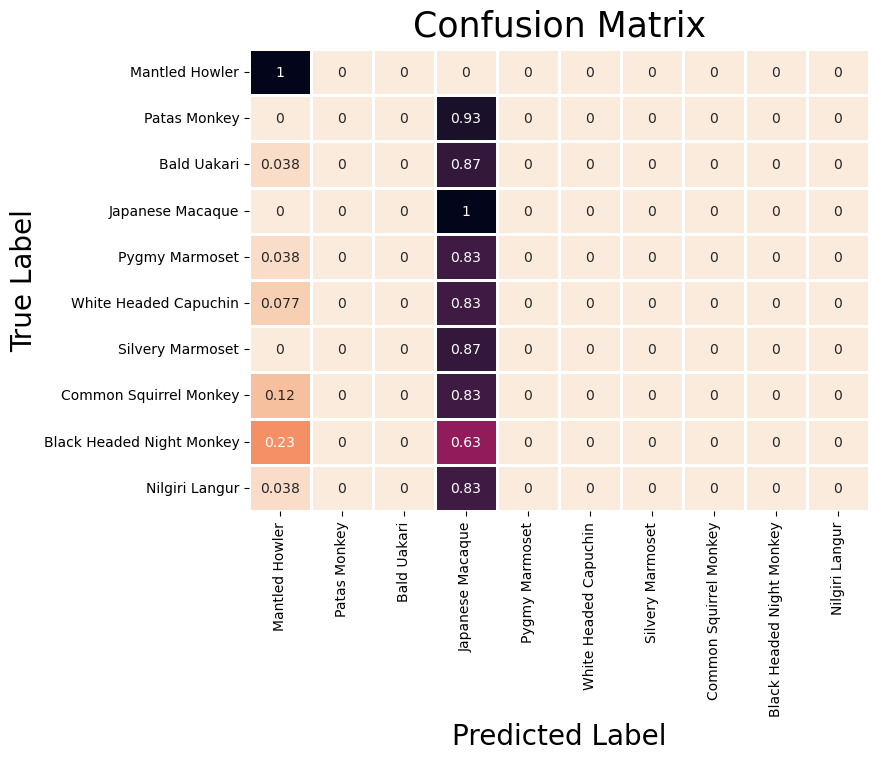

In [39]:
# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize=(8, 6))
sns.heatmap(
    normalized_conf_mat,
    annot=True,
    cbar=False,
    xticklabels=monkey_names,
    yticklabels=monkey_names,
    cmap="rocket_r",
    linewidths=1,
)
plt.title("Confusion Matrix", size=25, y=1.01)
plt.xlabel("Predicted Label", size=20)
plt.ylabel("True Label", size=20)
plt.show()


Each time we train our model we will obtain different results since the training
process is not deterministic, however in general we should see relatively high
performance across the majority of different classes of monkeys. As always, it
is worth looking at some of the classes that were incorrectly predicted to see
if there are any similarities in the appearances of the monkeys. For example,
the following pairs of monkeys appear to have common characteristics:

- **Common Squirrel Monkey** and the **Black Headed Night Monkey**
- **Bald Uakari** and the **Japanese Macaque**
- **Nilgiri Langur** and the **Mantled Howler**


Again, each time we train this model, it will have a slightly different set of
misclassified images. However, in general, we will often see some common
patterns in the incorrectly identified images such as:

- the predicted monkey having similar characteristics to the true monkey
- images with multiple monkeys or juvenile monkeys
- poorly exposed images
- partialy occluded monkeys
- photos taken from odd angles
